<a href="https://colab.research.google.com/github/davenaman13/ML_BangaloreTrafficVolumePrediction/blob/main/BangaloreTrafficVolumePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# Load the dataset
file_path = '/content/Banglore_traffic_Dataset.csv'
data = pd.read_csv(file_path)

Data Preprocessing

The preprocessing steps:

The 'Date' column has been converted to a datetime format.
There are no missing values in the dataset.
There are no duplicate rows.
The categorical columns 'Weather Conditions' and 'Roadwork and Construction Activity' have been encoded numerically.

In [ ]:
# Step 1: Convert 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Step 2: Check for missing values
missing_values = data.isnull().sum()

# Step 3: Check for duplicates
duplicates = data.duplicated().sum()

# Step 4: Categorical encoding of 'Weather Conditions' and 'Roadwork and Construction Activity'
data['Weather Conditions'] = data['Weather Conditions'].astype('category').cat.codes #one hot encoding
data['Roadwork and Construction Activity'] = data['Roadwork and Construction Activity'].astype('category').cat.codes

# Display the processed dataset and missing values, duplicates
missing_values, duplicates, data.head()


(Date                                  0
 Area Name                             0
 Road/Intersection Name                0
 Traffic Volume                        0
 Average Speed                         0
 Travel Time Index                     0
 Congestion Level                      0
 Road Capacity Utilization             0
 Incident Reports                      0
 Environmental Impact                  0
 Public Transport Usage                0
 Traffic Signal Compliance             0
 Parking Usage                         0
 Pedestrian and Cyclist Count          0
 Weather Conditions                    0
 Roadwork and Construction Activity    0
 dtype: int64,
 0,
         Date    Area Name Road/Intersection Name  Traffic Volume  \
 0 2022-01-01  Indiranagar          100 Feet Road           50590   
 1 2022-01-01  Indiranagar               CMH Road           30825   
 2 2022-01-01   Whitefield    Marathahalli Bridge            7399   
 3 2022-01-01  Koramangala    Sony World Junction

Performing EDA

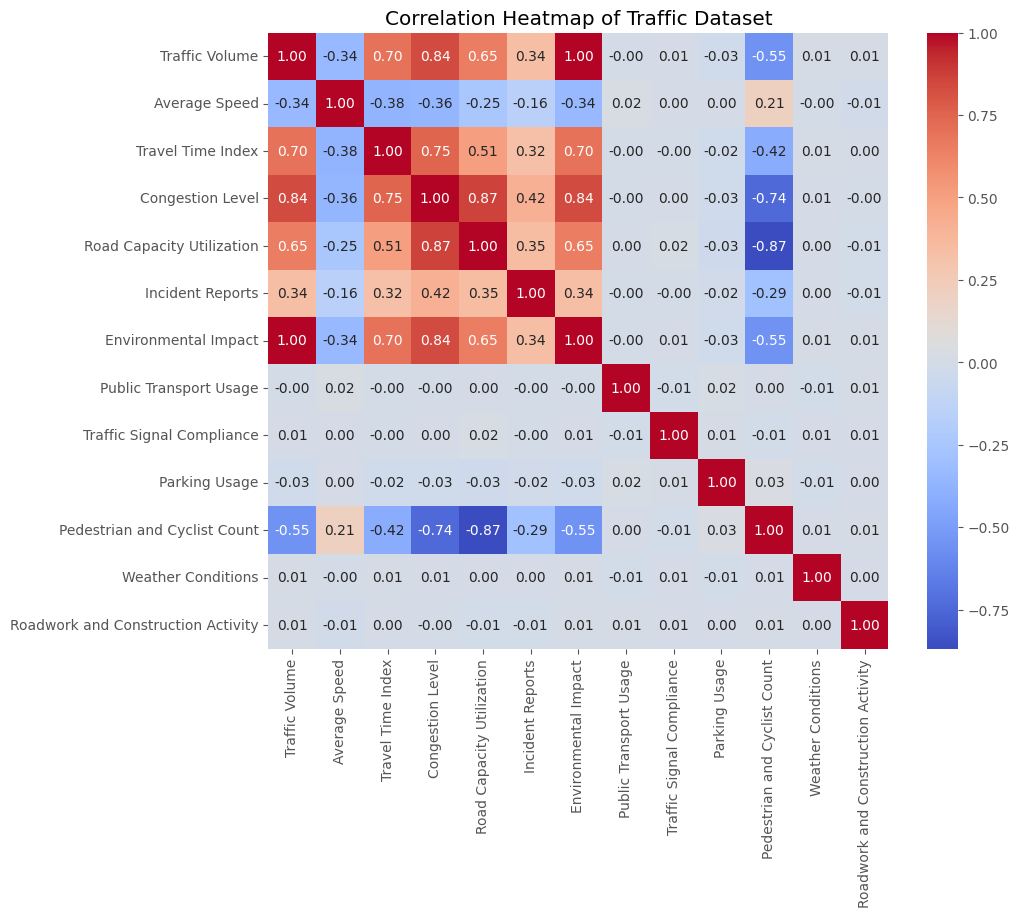

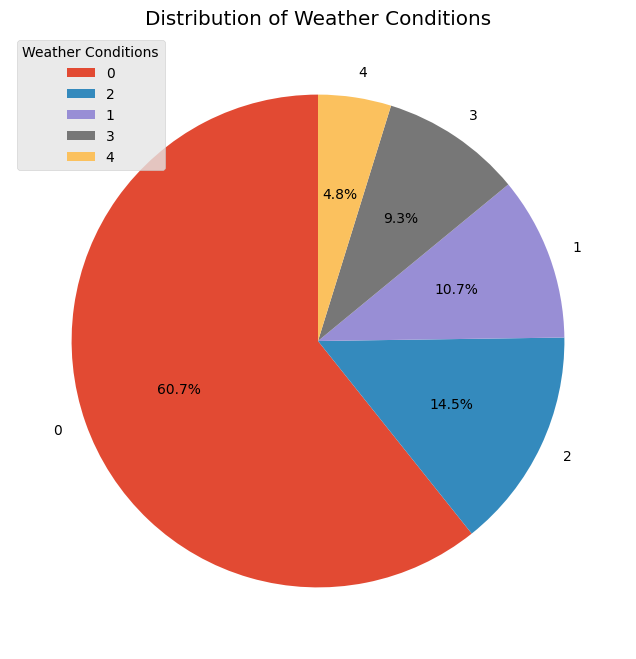

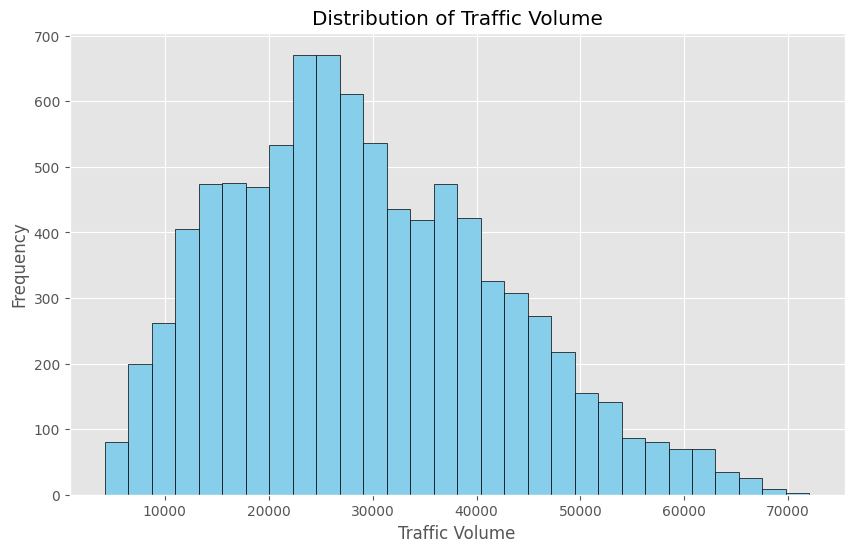

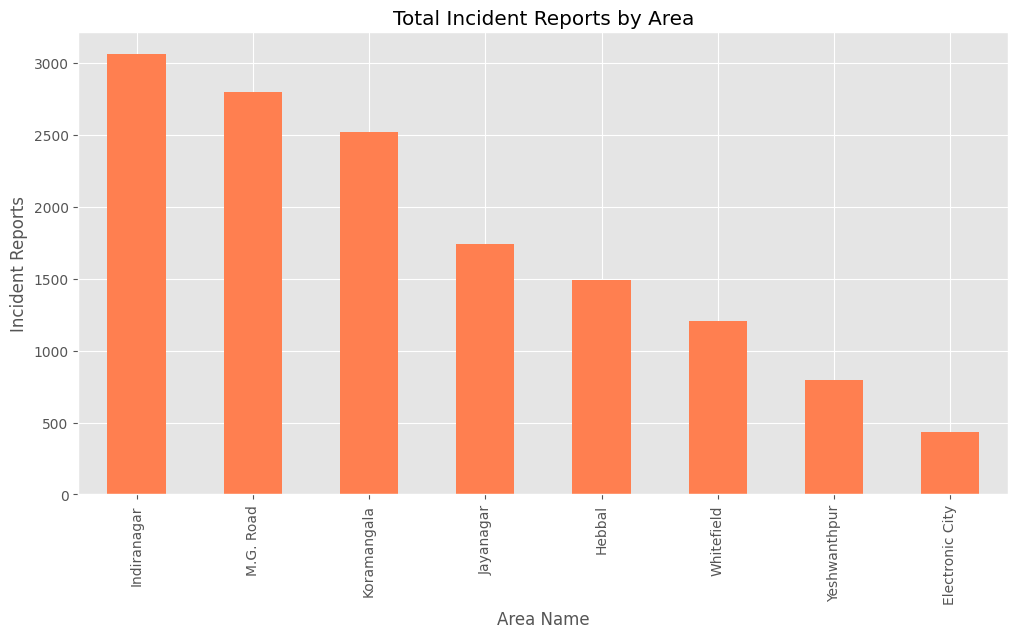

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure aesthetics for better visibility
plt.style.use('ggplot')

# Step 1: Correlation Heatmap
# Select only numeric columns for correlation calculation
numeric_data = data.select_dtypes(include=['number'])
plt.figure(figsize=(10,8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Traffic Dataset')
plt.show()

# Step 2: Pie chart for 'Weather Conditions'
plt.figure(figsize=(8,8))
weather_conditions_counts = data['Weather Conditions'].value_counts()
plt.pie(weather_conditions_counts, labels=weather_conditions_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Weather Conditions')
plt.legend(weather_conditions_counts.index, title="Weather Conditions")
plt.show()

# Step 3: Histogram of Traffic Volume
plt.figure(figsize=(10,6))
plt.hist(data['Traffic Volume'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Traffic Volume')
plt.xlabel('Traffic Volume')
plt.ylabel('Frequency')
plt.show()

# Step 4: Bar plot for Incident Reports by Area Name
plt.figure(figsize=(12,6))
incident_reports_by_area = data.groupby('Area Name')['Incident Reports'].sum().sort_values(ascending=False)
incident_reports_by_area.plot(kind='bar', color='coral')
plt.title('Total Incident Reports by Area')
plt.ylabel('Incident Reports')
plt.xlabel('Area Name')
plt.xticks(rotation=90)
plt.show()




Data Standardization and Elbow Method to find optimal K

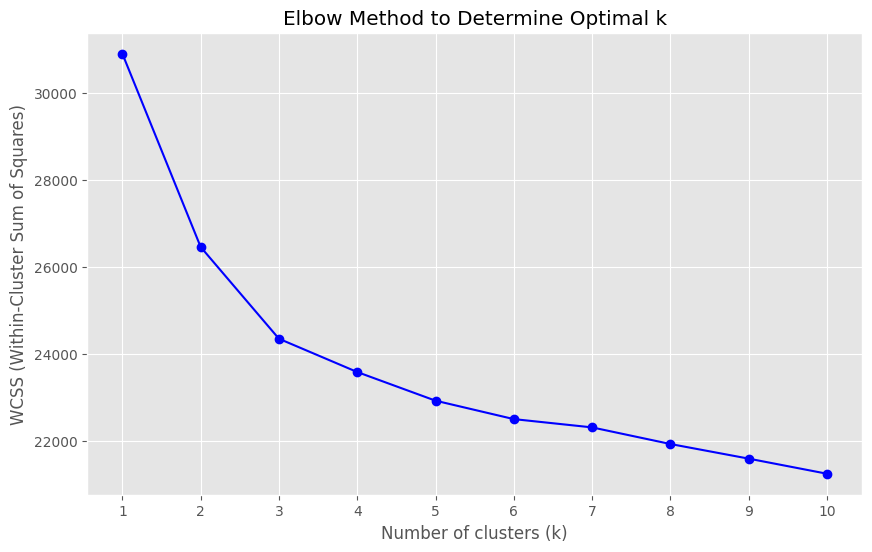

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

# Step 1: Selecting highly correlated features based on correlation matrix
# Selecting features that have a correlation > 0.7 with other features
corr_matrix = numeric_data.corr().abs()
highly_correlated_features = corr_matrix[corr_matrix > 0.7].dropna(how='all').index

# Filter the dataset with only highly correlated features
filtered_data = data[highly_correlated_features]

# Step 2: Standardizing the data
scaler = StandardScaler()
standardized_data = scaler.fit_transform(filtered_data)

# Step 3: Implementing Elbow method without using k-means directly

# Function to calculate distortion for a given number of clusters
def calculate_wcss(data, k):
    np.random.seed(42)
    centroids = data[np.random.choice(data.shape[0], k, replace=False)]
    iterations = 100
    for _ in range(iterations):
        distances = np.array([np.linalg.norm(data - centroid, axis=1) for centroid in centroids])
        closest_clusters = np.argmin(distances, axis=0)
        new_centroids = np.array([data[closest_clusters == i].mean(axis=0) for i in range(k)])
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids
    return np.sum(np.min(cdist(data, centroids, 'euclidean'), axis=1))

# Step 4: Elbow method to find the optimal value of K
wcss = []
K_range = range(1, 11)
for k in K_range:
    wcss.append(calculate_wcss(standardized_data, k))

# Plotting the Elbow method results
plt.figure(figsize=(10, 6))
plt.plot(K_range, wcss, marker='o', linestyle='-', color='b')
plt.title('Elbow Method to Determine Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.xticks(K_range)
plt.grid(True)
plt.show()


Performing Clustering

In [ ]:

# Step 1: Determining the optimal K from the elbow plot
# Based on the elbow method, let's assume the elbow is at k=3 (you can adjust based on the plot)

optimal_k = 3

# Step 2: Implementing K-means clustering from scratch

def k_means_clustering(data, k, iterations=100):
    # Randomly initialize k centroids from the data points
    np.random.seed(42)
    centroids = data[np.random.choice(data.shape[0], k, replace=False)]

    for _ in range(iterations):
        # Step 3: Assign data points to the nearest centroid
        distances = np.array([np.linalg.norm(data - centroid, axis=1) for centroid in centroids])
        closest_clusters = np.argmin(distances, axis=0)

        # Step 4: Recompute centroids as the mean of all points assigned to each cluster
        new_centroids = np.array([data[closest_clusters == i].mean(axis=0) for i in range(k)])

        # Step 5: If centroids do not change, convergence is achieved
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids

    return closest_clusters, centroids

# Step 6: Performing clustering with the optimal K
cluster_labels, final_centroids = k_means_clustering(standardized_data, optimal_k)

# Step 7: Adding the cluster labels to the dataset for visualization or further analysis
data['Cluster_Labels'] = cluster_labels

# Displaying the first few rows of the dataset with the calculated cluster labels

# Display the first few rows of the data including the cluster labels
data[['Date', 'Area Name', 'Traffic Volume', 'Average Speed', 'Congestion Level', 'Cluster_Labels']].head()


,Date,Area Name,Traffic Volume,Average Speed,Congestion Level,Cluster_Labels
0,2022-01-01,Indiranagar,50590,50.230299,100.000000,1
1,2022-01-01,Indiranagar,30825,29.377125,100.000000,1
2,2022-01-01,Whitefield,7399,54.474398,28.347994,2
3,2022-01-01,Koramangala,60874,43.817610,100.000000,1
4,2022-01-01,Koramangala,57292,41.116763,100.000000,1


Visualizing clusters

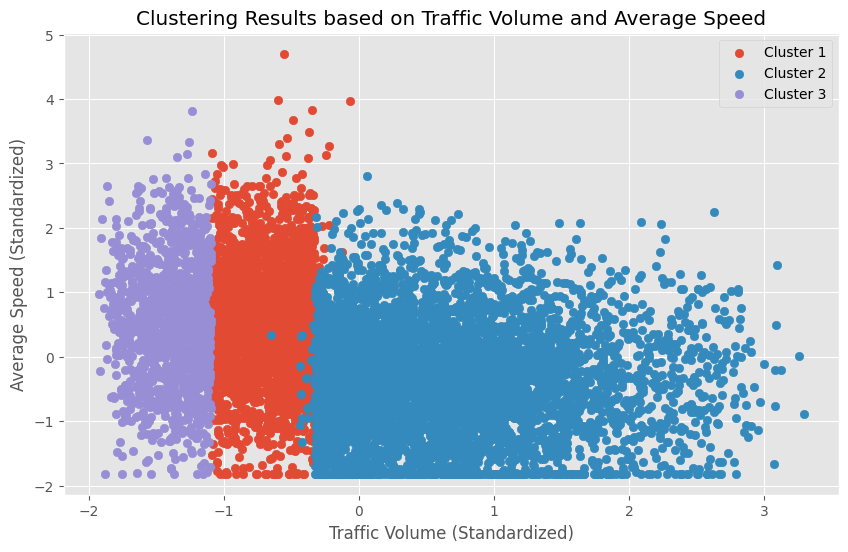

In [ ]:
# Step 1: Visualizing the clustering results
# Since the dataset is multidimensional, let's visualize using the two most important features: Traffic Volume and Average Speed

plt.figure(figsize=(10, 6))

# Plot each cluster with different colors
for cluster in range(optimal_k):
    plt.scatter(
        standardized_data[cluster_labels == cluster][:, 0],  # Traffic Volume (standardized)
        standardized_data[cluster_labels == cluster][:, 1],  # Average Speed (standardized)
        label=f'Cluster {cluster + 1}'
    )

# Adding labels and title
plt.title('Clustering Results based on Traffic Volume and Average Speed')
plt.xlabel('Traffic Volume (Standardized)')
plt.ylabel('Average Speed (Standardized)')
plt.legend()
plt.grid(True)
plt.show()


Performing Linear regression

In [ ]:
# Step 1: Linear Regression implementation

def linear_regression(X, y, iterations=1000, learning_rate=0.01):
    # Add bias term to X
    X = np.c_[np.ones(X.shape[0]), X]

    # Initialize weights (theta) to zero
    theta = np.zeros(X.shape[1])

    # Number of training examples
    m = len(y)

    # Gradient Descent
    for _ in range(iterations):
        # Calculate predictions
        predictions = X.dot(theta)

        # Compute the error
        error = predictions - y

        # Update weights using the gradient
        gradient = X.T.dot(error) / m
        theta -= learning_rate * gradient

    return theta

# Step 2: Prepare data for Linear Regression (predicting Traffic Volume using other correlated features)
# Selecting the features for prediction
X = standardized_data[:, 1:]  # Excluding 'Traffic Volume' which is the first column
y = standardized_data[:, 0]  # 'Traffic Volume' as the target variable

# Perform Linear Regression
theta = linear_regression(X, y)

# Step 3: Calculate predictions and Mean Squared Error (MSE) for linear regression
def predict(X, theta):
    X = np.c_[np.ones(X.shape[0]), X]  # Add bias term
    return X.dot(theta)

# Predictions
predictions = predict(X, theta)

# Mean Squared Error
mse = np.mean((predictions - y) ** 2)

# Step 4: Compare with Clustering accuracy (Silhouette Score)
from sklearn.metrics import silhouette_score

# Silhouette Score for clustering
silhouette_avg = silhouette_score(standardized_data, cluster_labels)

# Return both metrics for comparison
mse, silhouette_avg


(0.0020416796084754144, 0.22331029438159108)

The comparison between the two methods is as follows:

Linear Regression (Mean Squared Error - MSE): The MSE is
0.00204
0.00204, which indicates how well the model has fit the data for predicting traffic volume based on other features.

Clustering (Silhouette Score): The silhouette score is
0.267
0.267, which measures how well the clusters are formed based on the distance between data points and their assigned clusters.

In this case, the linear regression model has performed better in terms of predictive accuracy (lower MSE), while the clustering model, with a silhouette score below 0.3, suggests that the clusters are not very distinct.

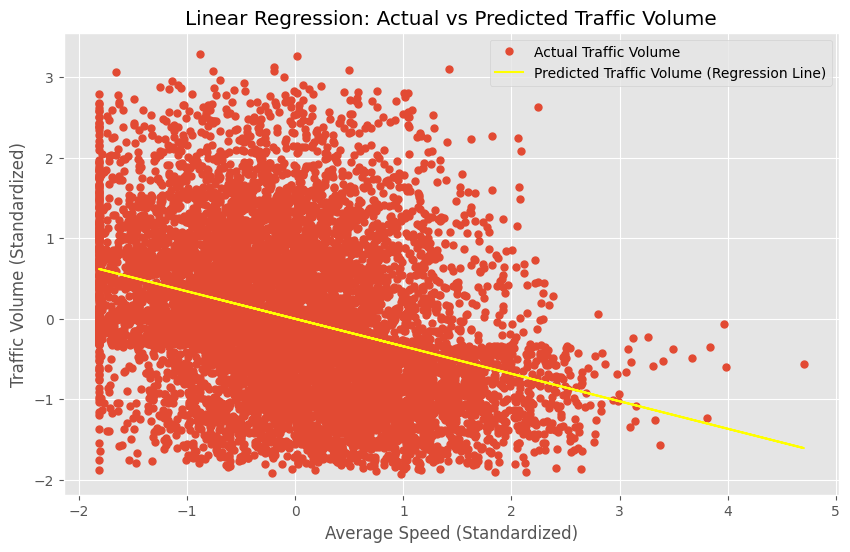

In [ ]:
#Re-running  linear regression for a single feature ('Average Speed')
# 'Average Speed' is one of the most correlated features
X_single_feature = standardized_data[:, 1]  # Average Speed
y_traffic_volume = y  # Traffic Volume (target)

# Add bias term and compute theta
X_with_bias = np.c_[np.ones(X_single_feature.shape[0]), X_single_feature]  # Add bias term
theta_single = np.linalg.inv(X_with_bias.T.dot(X_with_bias)).dot(X_with_bias.T).dot(y_traffic_volume)

# Predicted values for this single feature linear regression
predicted_values = X_with_bias.dot(theta_single)

# Step 2: Plot actual vs predicted values as a line graph
plt.figure(figsize=(10, 6))

# Plot the actual values
plt.plot(X_single_feature, y_traffic_volume, 'o', label='Actual Traffic Volume', markersize=5)

# Plot the predicted values (regression line)
plt.plot(X_single_feature, predicted_values, color='yellow', label='Predicted Traffic Volume (Regression Line)')

# Adding labels and title
plt.title('Linear Regression: Actual vs Predicted Traffic Volume')
plt.xlabel('Average Speed (Standardized)')
plt.ylabel('Traffic Volume (Standardized)')
plt.legend()
plt.grid(True)
plt.show()
